In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import pickle
from torch import Tensor
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from scipy.fft import rfft, rfftfreq, fft, fftfreq
import scipy
import time
import copy
from google.colab import drive

drive.mount('/content/drive')

# Load in Data
with open('/content/drive/MyDrive/CSE 481 Capstone/processed_data.npy', 'rb') as f:
    data = np.load(f)
print(data.shape)

Mounted at /content/drive
(17920, 4, 32, 32)


In [2]:
# Load in Labels
with open('/content/drive/MyDrive/CSE 481 Capstone/labels.npy', 'rb') as f:
    labels = np.load(f)
sub_labels = labels
print(sub_labels.shape)
sub_labels_2 = np.zeros((len(sub_labels)))
for i in range(len(sub_labels)):
  instance = sub_labels[i]
  valence = instance[0]
  arousal = instance[1]
  if (valence < 5 and arousal < 5):
    sub_labels_2[i] = 0
  elif (valence < 5 and arousal >= 5):
    sub_labels_2[i] = 1
  elif (valence >= 5 and arousal < 5):
    sub_labels_2[i] = 2
  else:
    sub_labels_2[i] = 3
#lb = preprocessing.LabelBinarizer()
#sub_labels_2 = lb.fit_transform(sub_labels_2)
print(sub_labels_2)

# convert to windowed labels
data_labels = np.repeat(sub_labels_2, 14, axis=0)
print(data_labels.shape)
print(data_labels)

#convert to tensor
#ata = torch.tensor(data)
data = torch.from_numpy(data).float()
data_labels = torch.from_numpy(data_labels).float()
print(data.dtype)
print(data.shape)
dataset = TensorDataset(Tensor(data) , Tensor(data_labels))

print(data[29][1])

(1280, 2)
[3. 3. 3. ... 1. 1. 2.]
(17920,)
[3. 3. 3. ... 2. 2. 2.]
torch.float32
torch.Size([17920, 4, 32, 32])
tensor([[ 1.0000,  0.6335,  0.4222,  ..., -0.0332,  0.3070,  0.1884],
        [ 0.6335,  1.0000,  0.8858,  ..., -0.0963,  0.4528,  0.2397],
        [ 0.4222,  0.8858,  1.0000,  ...,  0.0902,  0.4818,  0.2817],
        ...,
        [-0.0332, -0.0963,  0.0902,  ...,  1.0000,  0.4132,  0.5115],
        [ 0.3070,  0.4528,  0.4818,  ...,  0.4132,  1.0000,  0.7692],
        [ 0.1884,  0.2397,  0.2817,  ...,  0.5115,  0.7692,  1.0000]])


In [3]:
pre_train_size = int(0.9 * len(dataset))
test_size = len(dataset) - pre_train_size
pre_train_set, test_set = torch.utils.data.random_split(dataset, [pre_train_size, test_size])
train_size = int(0.8 * len(pre_train_set))
val_size = len(pre_train_set) - train_size
print(len(pre_train_set))
print(train_size)
print(val_size)
train_set, val_set = torch.utils.data.random_split(pre_train_set, [train_size, val_size])

batch_size = 128
print(len(train_set), len(val_set), len(test_set))
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
dataloaders = {
    'train': trainloader,
    'val': valloader,
}

16128
12902
3226
12902 3226 1792


In [4]:
# with auto encoder
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# skipped autoencoder
model = nn.Sequential(
    nn.Conv2d(4, 32, [3, 1]),
    nn.ReLU(),
    nn.Dropout(),
    nn.Conv2d(32, 64, [3, 1]),
    nn.ReLU(), # Maybe not sure
    nn.Dropout(),
    nn.MaxPool2d([3, 3]),
    nn.Flatten(),
    nn.Linear(5760, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 4)
)
model.to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

cuda:0
Sequential(
  (0): Conv2d(4, 32, kernel_size=[3, 1], stride=(1, 1))
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Conv2d(32, 64, kernel_size=[3, 1], stride=(1, 1))
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): MaxPool2d(kernel_size=[3, 3], stride=[3, 3], padding=0, dilation=1, ceil_mode=False)
  (7): Flatten(start_dim=1, end_dim=-1)
  (8): Linear(in_features=5760, out_features=512, bias=True)
  (9): ReLU()
  (10): Linear(in_features=512, out_features=256, bias=True)
  (11): ReLU()
  (12): Linear(in_features=256, out_features=4, bias=True)
)


In [5]:
since = time.time()
best_model_wts = copy.deepcopy(model.state_dict())
best_loss = 10000.0
all_train_loss = []
all_val_loss = []
num_epochs = 150
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            #print(inputs)
            #print(labels)
            

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                #print(outputs)
                _, preds = torch.max(outputs, 1)
                #print(preds)
                #print(outputs.dtype)
                #print(labels.dtype)
                loss = loss_func(outputs, labels.long())
                #print(loss.item())

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item()

                #print(running_loss)
                
                running_corrects += torch.sum(preds == labels.data) / inputs.size(0)

        epoch_loss = running_loss / len(dataloaders[phase])
        epoch_acc = running_corrects / len(dataloaders[phase])

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            phase, epoch_loss, epoch_acc))
        if phase == 'train':
          all_train_loss.append(epoch_loss)
        else:
          all_val_loss.append(epoch_loss)
        # deep copy the model
        # if phase == 'val' and epoch_acc > best_acc:
        #     best_acc = epoch_acc
        #     best_model_wts = copy.deepcopy(model.state_dict())
        if phase == 'val' and epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())

    print()

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
print('Best val Loss: {:4f}'.format(best_loss))

# load best model weights
model.load_state_dict(best_model_wts)

Epoch 0/149
----------
train Loss: 1.3906 Acc: 0.3539
val Loss: 1.3777 Acc: 0.3558

Epoch 1/149
----------
train Loss: 1.3522 Acc: 0.3635
val Loss: 1.3797 Acc: 0.3612

Epoch 2/149
----------
train Loss: 1.3335 Acc: 0.3762
val Loss: 1.3533 Acc: 0.3966

Epoch 3/149
----------
train Loss: 1.2934 Acc: 0.3939
val Loss: 1.3232 Acc: 0.3833

Epoch 4/149
----------
train Loss: 1.2669 Acc: 0.4173
val Loss: 1.3066 Acc: 0.4270

Epoch 5/149
----------
train Loss: 1.2417 Acc: 0.4318
val Loss: 1.2979 Acc: 0.4313

Epoch 6/149
----------
train Loss: 1.2164 Acc: 0.4522
val Loss: 1.2558 Acc: 0.4549

Epoch 7/149
----------
train Loss: 1.2008 Acc: 0.4602
val Loss: 1.2248 Acc: 0.4603

Epoch 8/149
----------
train Loss: 1.1803 Acc: 0.4687
val Loss: 1.2086 Acc: 0.4762

Epoch 9/149
----------
train Loss: 1.1649 Acc: 0.4807
val Loss: 1.1845 Acc: 0.4811

Epoch 10/149
----------
train Loss: 1.1481 Acc: 0.4879
val Loss: 1.1807 Acc: 0.4840

Epoch 11/149
----------
train Loss: 1.1451 Acc: 0.4945
val Loss: 1.1761 Acc

<All keys matched successfully>

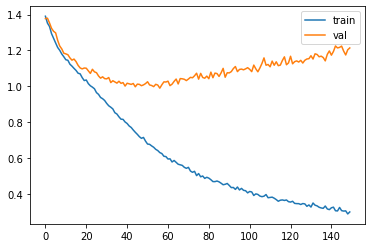

In [6]:
plt.plot(all_train_loss)
plt.plot(all_val_loss)
plt.legend(['train', 'val'])

In [7]:
running_loss = 0.0
running_corrects = 0
model.eval()

# Iterate over data.
for inputs, labels in testloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    loss = loss_func(outputs, labels.long())

    # statistics
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data) / inputs.size(0)
epoch_loss = running_loss / len(testloader)
print('Test Loss: {:.4f}'.format(epoch_loss))
print('Test Acc: {:.4f}'.format(running_corrects / len(testloader)))
print()

Test Loss: 1.0345
Test Acc: 0.5787



In [8]:
torch.save(model.state_dict(), '/content/drive/MyDrive/CSE 481 Capstone/model_multi.pth')

In [9]:
model.eval()
datatestiter = iter(testloader)
input_test, labels_test = datatestiter.next()
input_test = input_test.to(device)
labels_test = labels_test.to(device)
output_test = model(input_test)
_, preds = torch.max(output_test, 1)
print(preds.shape)
print(labels_test.shape)
print('preds',preds[0:8])
print('labels', labels_test[0:8])
print(torch.sum(preds == labels_test) / len(labels_test))

torch.Size([128])
torch.Size([128])
preds tensor([2, 1, 2, 0, 3, 3, 3, 2], device='cuda:0')
labels tensor([3., 1., 2., 3., 2., 3., 3., 2.], device='cuda:0')
tensor(0.5859, device='cuda:0')
